In [1]:
# Get Libraries
import pandas as pd 
import plotly.express as px
from matplotlib import pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV 

In [2]:
# GET DATA
df = pd.read_csv("C://Users/Joe/Desktop/GC_Traffic.txt")
df.columns  = ['temp']

# Sales Data
df['Sales'] = df.temp.apply(lambda x: int(x.split('\t')[-1]))

# Date Data
df['Date' ] = df.temp.apply(lambda x: x.split(' ')[0])
df.Date     = pd.to_datetime(df.Date,format='%d/%m/%y')
df['year' ] = df.Date.apply(lambda x: str(x).split('-')[0])
df['month'] = df.Date.apply(lambda x: str(x).split('-')[1])
df['date' ] = df.Date.apply(lambda x: str(x).split('-')[2].split(' ')[0])

df.year  = df.year.apply(lambda  x: int(x))
df.month = df.month.apply(lambda x: int(x))
df.date  = df.date.apply(lambda  x: int(x))

df.drop(columns=['Date','temp'], axis=1, inplace=True)

df.head()

,Sales,year,month,date
0,2093576,2016,1,1
1,2397260,2016,1,2
2,2173039,2016,1,3
3,2051240,2016,1,4
4,1954117,2016,1,5


In [3]:
index_2017 = df.query('year==2017 and month==1 and date==1').index[0] # Leap-Year 2016
index_2018 = df.query('year==2018 and month==1 and date==1').index[0]
index_2019 = df.query('year==2019 and month==1 and date==1').index[0]

print('Indexes are :', index_2017, index_2018, index_2019)

Indexes are : 366 731 1096


In [4]:
# Create Data for Supervised Learning

def prepare_data(dfs, starting_index, lags):
    
    sl_df = pd.DataFrame()    
    for i in range(starting_index,df.shape[0]):              
        a = pd.Series([dfs.Sales[i], dfs.date[i], dfs.month[i], dfs.year[i]])
        b = pd.Series(dfs.Sales[i-lags:i].values)
        c = a.append(b, ignore_index = True)    
        sl_df = sl_df.append(c, ignore_index=True)

    sl_df.columns = ['target', 'date', 'month', 'year']+['D'+str(i+1) for i in range(lags)]    
    return sl_df



def define_window(window='annually', days=365):
    if window=='annually':
        return index_2017, 365
    elif window=='semi-annually':
        return 183, 182          # 183 due to Leap year - 2016
    elif window=='monthly':        
        return 31, 30
    elif window=='weekly':
        return 7, 7
    else:
        return days, days
        

starting_index, lag_days = define_window('annually', 10)
sl_df = prepare_data(df, starting_index, lag_days)
sl_df.date, sl_df.month, sl_df.year = sl_df.date.apply(lambda x: int(x)), sl_df.month.apply(lambda x: int(x)), sl_df.year.apply(lambda x: int(x))        

sl_df.head(3)

,target,date,month,year,D1,D2,D3,D4,D5,D6,...,D356,D357,D358,D359,D360,D361,D362,D363,D364,D365
0,2002787.0,1,1,2017,2397260.0,2173039.0,2051240.0,1954117.0,1923592.0,1927622.0,...,8295627.0,11257897.0,9818129.0,2045569.0,3176649.0,3267285.0,3156262.0,3010110.0,3261470.0,3050193.0
1,2308711.0,2,1,2017,2173039.0,2051240.0,1954117.0,1923592.0,1927622.0,2074300.0,...,11257897.0,9818129.0,2045569.0,3176649.0,3267285.0,3156262.0,3010110.0,3261470.0,3050193.0,2002787.0
2,2274992.0,3,1,2017,2051240.0,1954117.0,1923592.0,1927622.0,2074300.0,2121106.0,...,9818129.0,2045569.0,3176649.0,3267285.0,3156262.0,3010110.0,3261470.0,3050193.0,2002787.0,2308711.0


In [5]:
sl_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
target,919.0,2.395257e+06,1.287029e+06,1216615.0,1841189.0,2117926.0,2469712.5,13714689.0
date,919.0,1.559956e+01,8.815010e+00,1.0,8.0,16.0,23.0,31.0
month,919.0,5.935800e+00,3.387985e+00,1.0,3.0,6.0,9.0,12.0
year,919.0,2.017808e+03,7.528405e-01,2017.0,2017.0,2018.0,2018.0,2019.0
D1,919.0,2.034454e+06,1.086932e+06,1061345.0,1559747.0,1792616.0,2115539.5,13714689.0
...,...,...,...,...,...,...,...,...
D361,919.0,2.399833e+06,1.288152e+06,1216615.0,1841189.0,2117978.0,2473142.0,13714689.0
D362,919.0,2.398643e+06,1.287855e+06,1216615.0,1841189.0,2117978.0,2472663.0,13714689.0
D363,919.0,2.397962e+06,1.287619e+06,1216615.0,1841189.0,2117978.0,2472663.0,13714689.0
D364,919.0,2.397419e+06,1.287466e+06,1216615.0,1841189.0,2117978.0,2472663.0,13714689.0


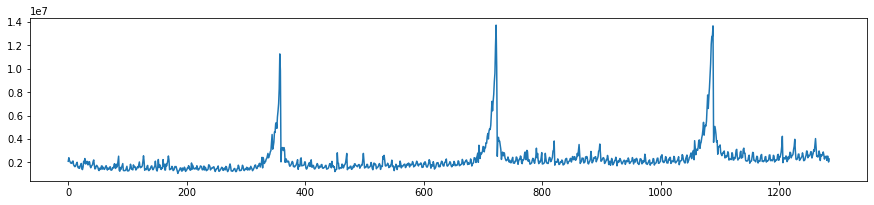

In [6]:
df.Sales.plot(figsize=(15,3))

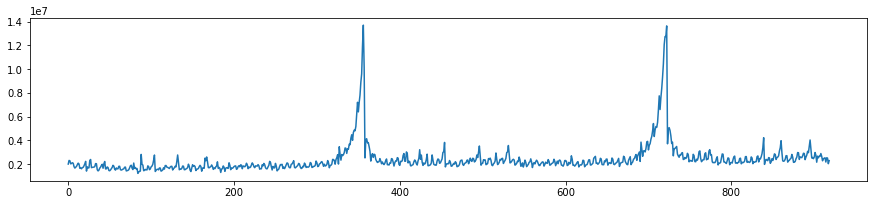

In [7]:
sl_df.target.plot(figsize=(15,3))

In [8]:
sl_df.head(3)

,target,date,month,year,D1,D2,D3,D4,D5,D6,...,D356,D357,D358,D359,D360,D361,D362,D363,D364,D365
0,2002787.0,1,1,2017,2397260.0,2173039.0,2051240.0,1954117.0,1923592.0,1927622.0,...,8295627.0,11257897.0,9818129.0,2045569.0,3176649.0,3267285.0,3156262.0,3010110.0,3261470.0,3050193.0
1,2308711.0,2,1,2017,2173039.0,2051240.0,1954117.0,1923592.0,1927622.0,2074300.0,...,11257897.0,9818129.0,2045569.0,3176649.0,3267285.0,3156262.0,3010110.0,3261470.0,3050193.0,2002787.0
2,2274992.0,3,1,2017,2051240.0,1954117.0,1923592.0,1927622.0,2074300.0,2121106.0,...,9818129.0,2045569.0,3176649.0,3267285.0,3156262.0,3010110.0,3261470.0,3050193.0,2002787.0,2308711.0


### Parameter Tuning for XGBoost

- Train Test Data Split

In [9]:
from sklearn.model_selection import train_test_split
X, y = sl_df.iloc[:,1:], sl_df.iloc[:,0:1]
print('X-y dimension = ', X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('Dimension',
      '\nX train =',X_train.shape, 
      '\nX_test  =',X_test.shape , 
      '\ny_train =',y_train.shape, 
      '\ny_test  =',y_test.shape) 

X-y dimension =  (919, 368) (919, 1)
Dimension 
X train = (735, 368) 
X_test  = (184, 368) 
y_train = (735, 1) 
y_test  = (184, 1)


- Metric Definition

In [10]:
def get_score(actual, predict, metric=4):    
    if metric == 1: 
        return abs(actual - predict).mean()               # Mean Absolute Error
    if metric == 2: 
        return ((actual - predict)**2).mean()             # Mean Squared Error
    if metric == 3: 
        return np.sqrt(((actual - predict)**2).mean())    # Root Mean Squared Error
    if metric == 4: 
        return abs((actual - predict)/actual*100).mean()  # Mean Absolute Percentage Error (Good for Relative Comparison)
    

- HyperParameter Setting using GridSearchCV

In [43]:
parameters = { 
              'learning_rate'   : [0.2, 0.3], 
              'max_depth'       : [3,5,8],
              'n_estimators'    : [100, 500]
             }

XGB_MDL_01  = xgb.XGBRegressor()
XGB_Grid_01 = GridSearchCV(XGB_MDL_01, parameters, cv = 5, n_jobs = -1)
XGB_Grid_01.fit(X_train, y_train)

print('\n Best Grid Score        =', XGB_Grid_01.best_score_,
      '\n Best Parameter Setting =', XGB_Grid_01.best_params_ )

# Best Grid Score        = 0.9375800030649412 
# Best Parameter Setting = {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 500}


 Best Grid Score        = 0.9375800030649412 
 Best Parameter Setting = {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 500}


In [44]:
parameters = {            
              'learning_rate'   : [0.15, 0.2, 0.25], 
              'max_depth'       : [6, 8, 10],
              'n_estimators'    : [500, 1000]
             }

XGB_MDL_02  = xgb.XGBRegressor()
XGB_Grid_02 = GridSearchCV(XGB_MDL_02, parameters, cv = 5, n_jobs = -1)
XGB_Grid_02.fit(X_train, y_train)

print('\n Best Grid Score        =', XGB_Grid_02.best_score_,
      '\n Best Parameter Setting =', XGB_Grid_02.best_params_ )

# Best Grid Score        = 0.9382100019763087 
# Best Parameter Setting = {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000}


 Best Grid Score        = 0.9382100019763087 
 Best Parameter Setting = {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000}


In [11]:
# Assign Best Parameter Setting

X_train, y_train = sl_df.drop(columns='target', axis=1), sl_df['target']

XGB_Model_Final = xgb.XGBRegressor(learning_rate = 0.2, max_depth = 5, n_estimators = 500)
XGB_Model_Final.fit(X_train,y_train)
XGB_Model_Final_pred = XGB_Model_Final.predict(X_train)

print('Mean Absolute Percentage Error = ', get_score(y_train, XGB_Model_Final_pred, 4))


Mean Absolute Percentage Error =  0.0024573902435886426


#### Plot XGBoost Prediction

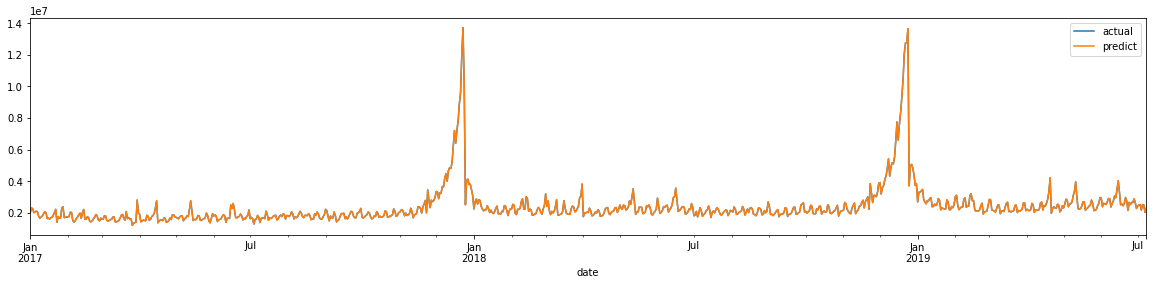

In [12]:
def plot_actual_predict(actual, predict, date, month, year):
            
    temp_df = pd.DataFrame()
    temp_df['actual']  = actual
    temp_df['predict'] = predict

    temp_df['date']    = date.astype(str) + '/' + month.astype(str) + '/' + year.astype(str)
    temp_df.date       = pd.to_datetime(temp_df.date,format='%d/%m/%Y')
    temp_df.set_index('date', inplace=True)

    temp_df[['actual','predict']].plot(figsize=(20,4))
    
    
X_train.date  = X_train.date.apply(lambda x: int(x))
X_train.month = X_train.month.apply(lambda x: int(x))
X_train.year  = X_train.year.apply(lambda x: int(x))

plot_actual_predict(y_train, XGB_Model_Final_pred, X_train.date, X_train.month, X_train.year)


### Use Previous Year Data to Predict Current Year Sales

#### Year-wise Training and Prediction

In [13]:
def iterative_train_test(dfs, target_year):
        
    X_train = dfs[dfs.year <  target_year].drop(columns=['target'], axis=1)
    X_test  = dfs[dfs.year == target_year].drop(columns=['target'], axis=1)
    y_train = dfs[dfs.year <  target_year].target
    y_test  = dfs[dfs.year == target_year].target
        
    XGB_Annual_Model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, 
                                        max_depth = 5, n_estimators = 500)
    XGB_Annual_Model.fit(X_train,y_train)        
    return XGB_Annual_Model.predict(X_test)    


#### Result Output

In [14]:
def plot_actual_predict(actual, predict, date, month, year):
        
    temp_df = pd.DataFrame()
    temp_df['actual']  = actual
    temp_df['predict'] = predict

    temp_df['date']    = date.astype(str) + '/' + month.astype(str) + '/' + year.astype(str)
    temp_df.date       = pd.to_datetime(temp_df.date,format='%d/%m/%Y')
    temp_df.set_index('date', inplace=True)

    temp_df[['actual','predict']].plot(figsize=(20,4))

#### Prediction of 2018 based on 2016-2017 Data

MAPE of 2018 Prediction is  9.580226403054203 % 


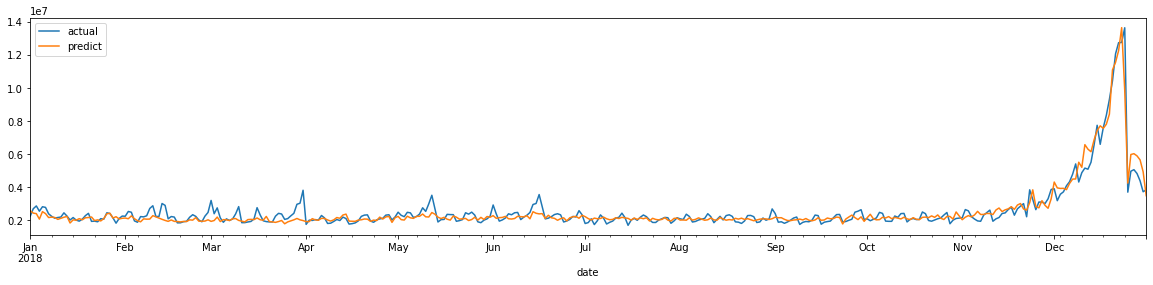

In [15]:
pred_2018 = iterative_train_test(sl_df, 2018)
print('MAPE of 2018 Prediction is ', get_score(sl_df.query('year==2018').target, pred_2018, 4), '% ')

plot_actual_predict(sl_df.query('year==2018').target, pred_2018, sl_df.date, sl_df.month, sl_df.year)

#### Prediction of 2019 based on 2016-2018 Data

MAPE of 2019 Prediction is  9.970565442057168 % 


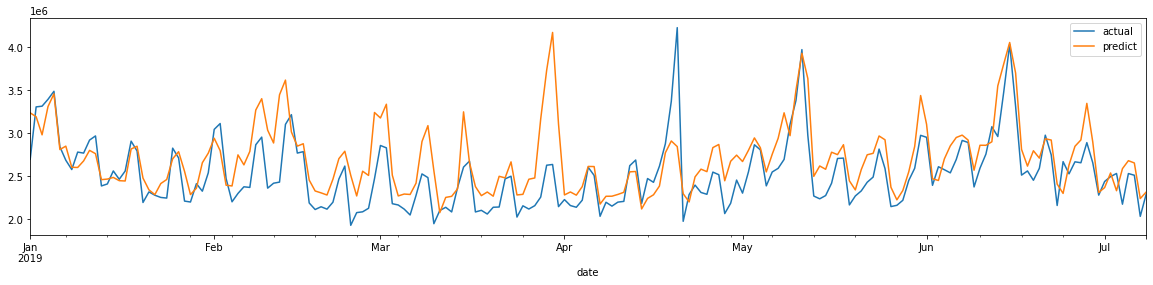

In [16]:
pred_2019 = iterative_train_test(sl_df, 2019)
print('MAPE of 2019 Prediction is ', get_score(sl_df.query('year==2019').target, pred_2019, 4), '% ')

plot_actual_predict(sl_df.query('year==2019').target, pred_2019, sl_df.date, sl_df.month, sl_df.year)

## Future Predictions

- User Defined Functions

In [17]:
from pandas.tseries.offsets import DateOffset

def predict_one_day(temp_df): 
    
    XGB = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, 
                                        max_depth = 5, n_estimators = 500)
    
    X_train, y_train = temp_df.drop(columns='target', axis=1).iloc[:-1,], temp_df.target.iloc[:-1,]
    X_test           = temp_df.drop(columns='target', axis=1).iloc[-1:,]
    
    XGB.fit(X_train, y_train)        
    
    return XGB.predict(X_test)

  

def add_record(temp_df, date, month, year, past_values):    
    temp_df = temp_df.append(temp_df.iloc[-1,:], ignore_index=True)    
    temp_df.iloc[-1,:] = [0] + [date] + [month] + [year] + past_values    
    return temp_df


def update_record(temp_df, window, date):
    year  = int(str(date).split('-')[0])
    month = int(str(date).split('-')[1])
    date  = int(str(date).split('-')[2].split(' ')[0])
    
    temp_df = add_record(temp_df, date, month, year, list(temp_df.target[-window:]))        
    temp_df.target.iloc[-1,] = predict_one_day(temp_df)
        
    return temp_df
    
    
def generate_new_date_dataframe(store_df, n_days):    
    temp_var         = str(store_df.date.iloc[-1,]) + '/' + str(store_df.month.iloc[-1,]) + '/' + str(store_df.year.iloc[-1,])
    current_date     = pd.to_datetime(temp_var, format='%d/%m/%Y')
    return pd.DataFrame([current_date + DateOffset(days=x) for x in range(1,1+n_days)], columns=['date'])


def predict_future_dates(store_df, new_date_df, window):    
    for i in range(new_date_df.shape[0]):
        store_df = update_record(store_df, window, new_date_df.date.iloc[i])        
    return store_df
        

- Perform Prediction

In [22]:
store_df = sl_df.copy()

n_days      = 179   
new_date_df = generate_new_date_dataframe(store_df, n_days)
store_df    = predict_future_dates(sl_df, new_date_df, 365)

store_df.tail(10)

,target,date,month,year,D1,D2,D3,D4,D5,D6,...,D356,D357,D358,D359,D360,D361,D362,D363,D364,D365
1088,4571631.0,25.0,12.0,2019.0,3710950.0,4979283.0,5070313.0,4838417.0,4397841.0,3736114.0,...,10867632.0,10725844.0,11046152.0,11141576.0,11421526.0,12716702.0,12619224.0,12742884.0,12878854.0,12554748.0
1089,10504838.0,26.0,12.0,2019.0,4979283.0,5070313.0,4838417.0,4397841.0,3736114.0,3849566.0,...,10725844.0,11046152.0,11141576.0,11421526.0,12716702.0,12619224.0,12742884.0,12878854.0,12554748.0,4571631.0
1090,9822598.0,27.0,12.0,2019.0,5070313.0,4838417.0,4397841.0,3736114.0,3849566.0,2696421.0,...,11046152.0,11141576.0,11421526.0,12716702.0,12619224.0,12742884.0,12878854.0,12554748.0,4571631.0,10504838.0
1091,6513446.0,28.0,12.0,2019.0,4838417.0,4397841.0,3736114.0,3849566.0,2696421.0,3305187.0,...,11141576.0,11421526.0,12716702.0,12619224.0,12742884.0,12878854.0,12554748.0,4571631.0,10504838.0,9822598.0
1092,4863807.5,29.0,12.0,2019.0,4397841.0,3736114.0,3849566.0,2696421.0,3305187.0,3313575.0,...,11421526.0,12716702.0,12619224.0,12742884.0,12878854.0,12554748.0,4571631.0,10504838.0,9822598.0,6513446.0
1093,4654674.5,30.0,12.0,2019.0,3736114.0,3849566.0,2696421.0,3305187.0,3313575.0,3393393.0,...,12716702.0,12619224.0,12742884.0,12878854.0,12554748.0,4571631.0,10504838.0,9822598.0,6513446.0,4863807.5
1094,3813959.0,31.0,12.0,2019.0,3849566.0,2696421.0,3305187.0,3313575.0,3393393.0,3486347.0,...,12619224.0,12742884.0,12878854.0,12554748.0,4571631.0,10504838.0,9822598.0,6513446.0,4863807.5,4654674.5
1095,3468875.0,1.0,1.0,2020.0,2696421.0,3305187.0,3313575.0,3393393.0,3486347.0,2841354.0,...,12742884.0,12878854.0,12554748.0,4571631.0,10504838.0,9822598.0,6513446.0,4863807.5,4654674.5,3813959.0
1096,3962469.0,2.0,1.0,2020.0,3305187.0,3313575.0,3393393.0,3486347.0,2841354.0,2685121.0,...,12878854.0,12554748.0,4571631.0,10504838.0,9822598.0,6513446.0,4863807.5,4654674.5,3813959.0,3468875.0
1097,4339146.5,3.0,1.0,2020.0,3313575.0,3393393.0,3486347.0,2841354.0,2685121.0,2576995.0,...,12554748.0,4571631.0,10504838.0,9822598.0,6513446.0,4863807.5,4654674.5,3813959.0,3468875.0,3962469.0


- Display Future Projection

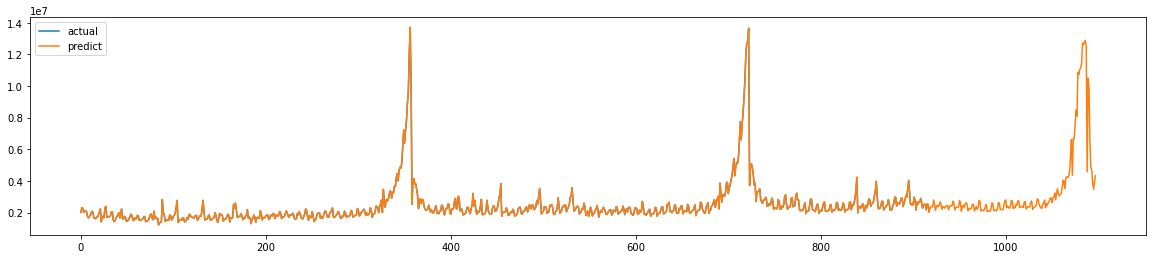

In [23]:
from numpy import asarray

XGB_output = pd.DataFrame()

predict = list(XGB_Model_Final_pred) + list(store_df.target.iloc[-n_days:,])
actual  = list(store_df.target.iloc[:-n_days,]) + [np.nan]*n_days

XGB_output['actual']  = actual
XGB_output['predict'] = predict

# Save as Excel - Use Actual Dates

XGB_output[['actual','predict']].plot(figsize=(20,4))

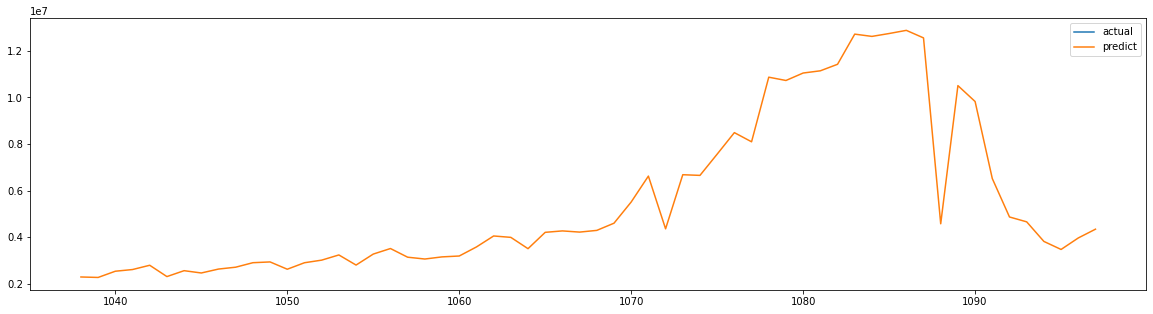

In [24]:
#print(Zoom_Last.tail(5))

Zoom_Last = XGB_output.iloc[-60:,]
Zoom_Last[['actual','predict']].plot(figsize=(20,5))

In [25]:
XGB_output.to_excel('output_xgb_large.xlsx')